<a href="https://colab.research.google.com/github/JapiKredi/RAG_assignment_Research_papers/blob/main/RAG_assignment_Research_papers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. <font color = red> Install and Import the Required Libraries

In [1]:
# Install all the required libraries
!pip install langchain
!pip install pdfplumber
!pip install tiktoken
#!pip install openai
!pip install chromaDB
!pip install chromadb
!pip install sentence-transformers
!pip install openai==0.28

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.6/803.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.3/230.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not insta

In [2]:
# Import all the required Libraries
import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb

In [3]:
!pip show langchain

Name: langchain
Version: 0.1.4
Summary: Building applications with LLMs through composability
Home-page: https://github.com/langchain-ai/langchain
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: aiohttp, async-timeout, dataclasses-json, jsonpatch, langchain-community, langchain-core, langsmith, numpy, pydantic, PyYAML, requests, SQLAlchemy, tenacity
Required-by: 


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. <font color = red> Read, Process, and Chunk the PDF Files

We will be using [pdfplumber](https://https://pypi.org/project/pdfplumber/) to read and process the PDF files.

`pdfplumber` allows for better parsing of the PDF file as it can read various elements of the PDF apart from the plain text, such as, tables, images, etc. It also offers wide functionaties and visual debugging features to help with advanced preprocessing as well.

In [5]:
single_pdf_path = "/content/drive/My Drive/GenerativeAI/MateAI/rag_assignment/research_articles/attention_all_you_need.pdf"

In [6]:
single_pdf_path

'/content/drive/My Drive/GenerativeAI/MateAI/rag_assignment/research_articles/attention_all_you_need.pdf'

#### <font color = red>  2.1 Reading a single PDF file and exploring it through pdfplumber


In [7]:
# Open the PDF file
with pdfplumber.open(single_pdf_path) as pdf:

    # Get one of the pages from the PDF and examine it
    single_page = pdf.pages[1]

    # Extract text from the first page
    text = single_page.extract_text()

    # Extract tables from the first page
    tables = single_page.extract_tables()

    # Print the extracted text
    print(text)

1 Introduction
Recurrentneuralnetworks,longshort-termmemory[13]andgatedrecurrent[7]neuralnetworks
inparticular,havebeenfirmlyestablishedasstateoftheartapproachesinsequencemodelingand
transductionproblemssuchaslanguagemodelingandmachinetranslation[35,2,5]. Numerous
effortshavesincecontinuedtopushtheboundariesofrecurrentlanguagemodelsandencoder-decoder
architectures[38,24,15].
Recurrentmodelstypicallyfactorcomputationalongthesymbolpositionsoftheinputandoutput
sequences. Aligningthepositionstostepsincomputationtime,theygenerateasequenceofhidden
statesh ,asafunctionoftheprevioushiddenstateh andtheinputforpositiont. Thisinherently
t t−1
sequentialnatureprecludesparallelizationwithintrainingexamples,whichbecomescriticalatlonger
sequencelengths,asmemoryconstraintslimitbatchingacrossexamples. Recentworkhasachieved
significantimprovementsincomputationalefficiencythroughfactorizationtricks[21]andconditional
computation[32],whilealsoimprovingmodelperformanceincaseofthelatter. Thefundamental
const

#### <font color = red> 2.2 Extracting text from multiple PDFs

Let's now try and read multiple documents, extract text from them using appropriate preprocessing, and store them in a dataframe


In [8]:
# Define the path where all pdf documents are present
pdf_path = "/content/drive/My Drive/GenerativeAI/MateAI/rag_assignment/"

In [9]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [10]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

*Now that we have defined the function for extracting the text and tables from a PDF, let's iterate and call this function for all the PDFs in our drive and store them in a list.*

In [11]:
# Define the directory containing the PDF files
pdf_directory = Path(pdf_path)

# Initialize an empty list to store the extracted texts and document names
data = []

# Loop through all files in the directory
for pdf_path in pdf_directory.glob("*.pdf"):

    # Process the PDF file
    print(f"...Processing {pdf_path.name}")

    # Call the function to extract the text from the PDF
    extracted_text = extract_text_from_pdf(pdf_path)

    # Convert the extracted list to a PDF, and add a column to store document names
    extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
    extracted_text_df['Document Name'] = pdf_path.name

    # Append the extracted text and document name to the list
    data.append(extracted_text_df)

    # Print a message to indicate progress
    print(f"Finished processing {pdf_path.name}")

# Print a message to indicate all PDFs have been processed
print("All PDFs have been processed.")

...Processing attention_all_you_need.pdf
Finished processing attention_all_you_need.pdf
All PDFs have been processed.


In [12]:
# Concatenate all the DFs in the list 'data' together
research_papers_data = pd.concat(data, ignore_index=True)

In [13]:
research_papers_data

,Page No.,Page_Text,Document Name
0,Page 1,"Providedproperattributionisprovided,Googlehere...",attention_all_you_need.pdf
1,Page 2,"1 Introduction Recurrentneuralnetworks,longsho...",attention_all_you_need.pdf
2,Page 3,Figure1: TheTransformer-modelarchitecture. The...,attention_all_you_need.pdf
3,Page 4,ScaledDot-ProductAttention Multi-HeadAttention...,attention_all_you_need.pdf
4,Page 5,output values. These are concatenated and once...,attention_all_you_need.pdf
5,Page 6,"Table1: Maximumpathlengths,per-layercomplexity...",attention_all_you_need.pdf
6,Page 7,length n is smaller than the representation di...,attention_all_you_need.pdf
7,Page 8,Table2: TheTransformerachievesbetterBLEUscores...,attention_all_you_need.pdf
8,Page 9,Table3: VariationsontheTransformerarchitecture...,attention_all_you_need.pdf
9,Page 10,Table4: TheTransformergeneralizeswelltoEnglish...,attention_all_you_need.pdf


In [14]:
# Let's also check the length of all the texts as there might be some empty pages or pages with very few words that we can drop
research_papers_data['Text_Length'] = research_papers_data['Page_Text'].apply(lambda x: len(x.split(' ')))

In [15]:
research_papers_data['Text_Length']

0     119
1     145
2      82
3      98
4     170
5     141
6     121
7     109
8     151
9     140
10    177
11    168
12    641
13    741
14    577
Name: Text_Length, dtype: int64

In [16]:
# Retain only the rows with a text length of at least 10
research_papers_data = research_papers_data.loc[research_papers_data['Text_Length'] >= 10]
research_papers_data

,Page No.,Page_Text,Document Name,Text_Length
0,Page 1,"Providedproperattributionisprovided,Googlehere...",attention_all_you_need.pdf,119
1,Page 2,"1 Introduction Recurrentneuralnetworks,longsho...",attention_all_you_need.pdf,145
2,Page 3,Figure1: TheTransformer-modelarchitecture. The...,attention_all_you_need.pdf,82
3,Page 4,ScaledDot-ProductAttention Multi-HeadAttention...,attention_all_you_need.pdf,98
4,Page 5,output values. These are concatenated and once...,attention_all_you_need.pdf,170
5,Page 6,"Table1: Maximumpathlengths,per-layercomplexity...",attention_all_you_need.pdf,141
6,Page 7,length n is smaller than the representation di...,attention_all_you_need.pdf,121
7,Page 8,Table2: TheTransformerachievesbetterBLEUscores...,attention_all_you_need.pdf,109
8,Page 9,Table3: VariationsontheTransformerarchitecture...,attention_all_you_need.pdf,151
9,Page 10,Table4: TheTransformergeneralizeswelltoEnglish...,attention_all_you_need.pdf,140


In [17]:
# Store the metadata for each page in a separate column
research_papers_data['Metadata'] = research_papers_data.apply(lambda x: {'Research_Paper': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)

In [18]:
research_papers_data

,Page No.,Page_Text,Document Name,Text_Length,Metadata
0,Page 1,"Providedproperattributionisprovided,Googlehere...",attention_all_you_need.pdf,119,"{'Research_Paper': 'attention_all_you_need', '..."
1,Page 2,"1 Introduction Recurrentneuralnetworks,longsho...",attention_all_you_need.pdf,145,"{'Research_Paper': 'attention_all_you_need', '..."
2,Page 3,Figure1: TheTransformer-modelarchitecture. The...,attention_all_you_need.pdf,82,"{'Research_Paper': 'attention_all_you_need', '..."
3,Page 4,ScaledDot-ProductAttention Multi-HeadAttention...,attention_all_you_need.pdf,98,"{'Research_Paper': 'attention_all_you_need', '..."
4,Page 5,output values. These are concatenated and once...,attention_all_you_need.pdf,170,"{'Research_Paper': 'attention_all_you_need', '..."
5,Page 6,"Table1: Maximumpathlengths,per-layercomplexity...",attention_all_you_need.pdf,141,"{'Research_Paper': 'attention_all_you_need', '..."
6,Page 7,length n is smaller than the representation di...,attention_all_you_need.pdf,121,"{'Research_Paper': 'attention_all_you_need', '..."
7,Page 8,Table2: TheTransformerachievesbetterBLEUscores...,attention_all_you_need.pdf,109,"{'Research_Paper': 'attention_all_you_need', '..."
8,Page 9,Table3: VariationsontheTransformerarchitecture...,attention_all_you_need.pdf,151,"{'Research_Paper': 'attention_all_you_need', '..."
9,Page 10,Table4: TheTransformergeneralizeswelltoEnglish...,attention_all_you_need.pdf,140,"{'Research_Paper': 'attention_all_you_need', '..."


This concludes the chunking aspect also, as we can see that mostly the pages contain few hundred words, maximum going upto 1000. So, we don't need to chunk the documents further; we can perform the embeddings on individual pages. This strategy makes sense for 2 reasons:
1. The way insurance documents are generally structured, you will not have a lot of extraneous information in a page, and all the text pieces in that page will likely be interrelated.
2. We want to have larger chunk sizes to be able to pass appropriate context to the LLM during the generation layer.


## 3. <font color = red> Generate and Store Embeddings using OpenAI and ChromaDB

In this section, we will embed the pages in the dataframe through OpenAI's `text-embedding-ada-002` model, and store them in a ChromaDB collection.

In [19]:
# Set the API key
filepath = "/content/drive/My Drive/GenerativeAI/MateAI/"

with open(filepath + "Jasper_OpenAI_API_Key.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())

In [20]:
# Import the OpenAI Embedding Function into chroma
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [21]:
# Define the path where chroma collections will be stored
chroma_data_path = '/content/drive/My Drive/GenerativeAI/MateAI/rag_assignment/ChromaDB_Data'

In [22]:
# Call PersistentClient()
client = chromadb.PersistentClient(path=chroma_data_path)

In [23]:
# Set up the embedding function using the OpenAI embedding model
model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)

In [24]:
# Initialise a collection in chroma and pass the embedding_function to it so that it used OpenAI embeddings to embed the documents
research_paper_collection = client.get_or_create_collection(name='RAG_on_Research_Paper', embedding_function=embedding_function)

In [25]:
# Convert the page text and metadata from your dataframe to lists to be able to pass it to chroma
documents_list = research_papers_data["Page_Text"].tolist()
metadata_list = research_papers_data['Metadata'].tolist()

In [26]:
metadata_list

[{'Research_Paper': 'attention_all_you_need', 'Page_No.': 'Page 1'},
 {'Research_Paper': 'attention_all_you_need', 'Page_No.': 'Page 2'},
 {'Research_Paper': 'attention_all_you_need', 'Page_No.': 'Page 3'},
 {'Research_Paper': 'attention_all_you_need', 'Page_No.': 'Page 4'},
 {'Research_Paper': 'attention_all_you_need', 'Page_No.': 'Page 5'},
 {'Research_Paper': 'attention_all_you_need', 'Page_No.': 'Page 6'},
 {'Research_Paper': 'attention_all_you_need', 'Page_No.': 'Page 7'},
 {'Research_Paper': 'attention_all_you_need', 'Page_No.': 'Page 8'},
 {'Research_Paper': 'attention_all_you_need', 'Page_No.': 'Page 9'},
 {'Research_Paper': 'attention_all_you_need', 'Page_No.': 'Page 10'},
 {'Research_Paper': 'attention_all_you_need', 'Page_No.': 'Page 11'},
 {'Research_Paper': 'attention_all_you_need', 'Page_No.': 'Page 12'},
 {'Research_Paper': 'attention_all_you_need', 'Page_No.': 'Page 13'},
 {'Research_Paper': 'attention_all_you_need', 'Page_No.': 'Page 14'},
 {'Research_Paper': 'attentio

In [27]:
# Add the documents and metadata to the collection alongwith generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.

research_paper_collection.add(
    documents= documents_list,
    ids = [str(i) for i in range(0, len(documents_list))],
    metadatas = metadata_list)

# Add the documents and metadata to the collection alongwith generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.

#research_paper_collection.add(
#    documents= documents_list,
#    ids = [str(i) for i in range(0, len(documents_list))],
#    metadatas = metadata_list,
#    embedding_function=openai.Embedding.create
#)

In [28]:
# Let's take a look at the first few entries in the collection
#research_paper_collection.get(
#    ids = ['0','1','2'],
#    include = ['embeddings', 'documents', 'metadatas']
#)

In [29]:
# Initialise a collection in chroma and pass the embedding_function to it so that it used OpenAI embeddings to embed the documents
cache_collection = client.get_or_create_collection(name='RAG_on_Research_Paper_Cache', embedding_function=embedding_function)

In [30]:
cache_collection.peek()

{'ids': [],
 'embeddings': [],
 'metadatas': [],
 'documents': [],
 'uris': None,
 'data': None}

## 4. <font color = red> Semantic Search with Cache

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [31]:
# Read the user query
query = input()

What is self-attention?


In [32]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results

cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

In [33]:
cache_results

{'ids': [[]],
 'distances': [[]],
 'metadatas': [[]],
 'embeddings': None,
 'documents': [[]],
 'uris': None,
 'data': None}

In [34]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = research_paper_collection.query(
      query_texts=query,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys = []
      Values = []

      for key, val in results.items():
        if key != 'embeddings':
          for i in range(10):
            Keys.append(str(key)+str(i))
            if val is not None:
              if val[0][i] is not None:
                Values.append(str(val[0][i]))

      cache_collection.add(
          documents= [query],
          ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")

      result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              metadatas.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })


Not found in cache. Found in main collection.


In [35]:
results_df

,Metadatas,Documents,Distances,IDs
0,"{'Page_No.': 'Page 1', 'Research_Paper': 'atte...","Providedproperattributionisprovided,Googlehere...",0.394108,0
1,"{'Page_No.': 'Page 4', 'Research_Paper': 'atte...",ScaledDot-ProductAttention Multi-HeadAttention...,0.423799,3
2,"{'Page_No.': 'Page 13', 'Research_Paper': 'att...",Input-Input Layer5 AttentionVisualizations [[n...,0.428395,12
3,"{'Page_No.': 'Page 6', 'Research_Paper': 'atte...","Table1: Maximumpathlengths,per-layercomplexity...",0.434196,5
4,"{'Page_No.': 'Page 5', 'Research_Paper': 'atte...",output values. These are concatenated and once...,0.448479,4
5,"{'Page_No.': 'Page 12', 'Research_Paper': 'att...","[25] MitchellPMarcus,MaryAnnMarcinkiewicz,andB...",0.461018,11
6,"{'Page_No.': 'Page 3', 'Research_Paper': 'atte...",Figure1: TheTransformer-modelarchitecture. The...,0.464081,2
7,"{'Page_No.': 'Page 2', 'Research_Paper': 'atte...","1 Introduction Recurrentneuralnetworks,longsho...",0.464224,1
8,"{'Page_No.': 'Page 15', 'Research_Paper': 'att...","Input-Input Layer5 [[null, """", null, """", null,...",0.466364,14
9,"{'Page_No.': 'Page 14', 'Research_Paper': 'att...","Input-Input Layer5 [[null, """", null, """", null,...",0.476406,13




```
# This is formatted as code
```

## 5. <font color = red> Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

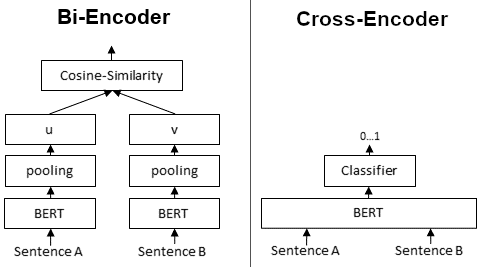

<br>

In [36]:
# Import the CrossEncoder library from sentence_transformers
from sentence_transformers import CrossEncoder, util

In [37]:
# Initialise the cross encoder model
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [38]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [39]:
cross_rerank_scores

array([ -8.5263195,  -6.992203 ,  -8.097818 ,  -2.0028286,  -1.8913145,
       -10.989975 ,  -7.804399 ,  -9.795794 , -10.713116 , -10.575146 ],
      dtype=float32)

In [40]:
# Store the rerank_scores in results_df
results_df['Reranked_scores'] = cross_rerank_scores

In [41]:
results_df

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 1', 'Research_Paper': 'atte...","Providedproperattributionisprovided,Googlehere...",0.394108,0,-8.526320
1,"{'Page_No.': 'Page 4', 'Research_Paper': 'atte...",ScaledDot-ProductAttention Multi-HeadAttention...,0.423799,3,-6.992203
2,"{'Page_No.': 'Page 13', 'Research_Paper': 'att...",Input-Input Layer5 AttentionVisualizations [[n...,0.428395,12,-8.097818
3,"{'Page_No.': 'Page 6', 'Research_Paper': 'atte...","Table1: Maximumpathlengths,per-layercomplexity...",0.434196,5,-2.002829
4,"{'Page_No.': 'Page 5', 'Research_Paper': 'atte...",output values. These are concatenated and once...,0.448479,4,-1.891315
5,"{'Page_No.': 'Page 12', 'Research_Paper': 'att...","[25] MitchellPMarcus,MaryAnnMarcinkiewicz,andB...",0.461018,11,-10.989975
6,"{'Page_No.': 'Page 3', 'Research_Paper': 'atte...",Figure1: TheTransformer-modelarchitecture. The...,0.464081,2,-7.804399
7,"{'Page_No.': 'Page 2', 'Research_Paper': 'atte...","1 Introduction Recurrentneuralnetworks,longsho...",0.464224,1,-9.795794
8,"{'Page_No.': 'Page 15', 'Research_Paper': 'att...","Input-Input Layer5 [[null, """", null, """", null,...",0.466364,14,-10.713116
9,"{'Page_No.': 'Page 14', 'Research_Paper': 'att...","Input-Input Layer5 [[null, """", null, """", null,...",0.476406,13,-10.575146


In [42]:
# Return the top 3 results from semantic search
top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 1', 'Research_Paper': 'atte...","Providedproperattributionisprovided,Googlehere...",0.394108,0,-8.526320
1,"{'Page_No.': 'Page 4', 'Research_Paper': 'atte...",ScaledDot-ProductAttention Multi-HeadAttention...,0.423799,3,-6.992203
2,"{'Page_No.': 'Page 13', 'Research_Paper': 'att...",Input-Input Layer5 AttentionVisualizations [[n...,0.428395,12,-8.097818


In [43]:
# Return the top 3 results after reranking
top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
4,"{'Page_No.': 'Page 5', 'Research_Paper': 'atte...",output values. These are concatenated and once...,0.448479,4,-1.891315
3,"{'Page_No.': 'Page 6', 'Research_Paper': 'atte...","Table1: Maximumpathlengths,per-layercomplexity...",0.434196,5,-2.002829
1,"{'Page_No.': 'Page 4', 'Research_Paper': 'atte...",ScaledDot-ProductAttention Multi-HeadAttention...,0.423799,3,-6.992203


In [44]:
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]

In [45]:
top_3_RAG

,Documents,Metadatas
4,output values. These are concatenated and once...,"{'Page_No.': 'Page 5', 'Research_Paper': 'atte..."
3,"Table1: Maximumpathlengths,per-layercomplexity...","{'Page_No.': 'Page 6', 'Research_Paper': 'atte..."
1,ScaledDot-ProductAttention Multi-HeadAttention...,"{'Page_No.': 'Page 4', 'Research_Paper': 'atte..."


## 6. Retrieval Augmented Generation

Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [46]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, results_df):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{top_3_RAG}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.

                                                """},
              ]

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response['choices'][0]['message']['content'].split('\n')

In [47]:
# Generate the response
response = generate_response(query, top_3_RAG)

In [48]:
# Print the response
print("\n".join(response))

Self-attention is a mechanism used in deep learning models, particularly in the field of natural language processing. It allows the model to weigh the importance of different words or tokens within the input sequence when making predictions or generating representations. 
The self-attention mechanism calculates the attention score for each word/token in the sequence by considering the interactions and relationships between all the other words/tokens in the sequence. This helps the model to focus on the most relevant information while ignoring irrelevant or redundant information.

In the context of insurance policies and documents, self-attention may not be directly applicable. It is a concept primarily used in deep learning models for processing text data. While insurance policies may involve the use of machine learning or NLP techniques, self-attention specifically refers to a mechanism within those models.

Unfortunately, self-attention is not directly relevant to the insurance docum

# 2nd solution using Langchain
## LangChain multi-doc retriever with ChromaDB

***New Points***
- Multiple Files - PDFs
- ChromaDB - with more meta data?
- Source info
- gpt-3.5-turbo API
- HuggingFace Embeddings



## 1. <font color = red> Install and Import the Required Libraries

## Setting up LangChain


In [50]:
# Install all the required libraries
!pip install langchain
!pip pypdf
!pip install tiktoken
!pip install openai
!pip install chromaDB
!pip install chromadb
!pip install sentence-transformers
!pip InstructorEmbedding

ERROR: unknown command "pypdf"
ERROR: unknown command "InstructorEmbedding"


In [51]:
!pip -q install langchain openai tiktoken chromadb pypdf sentence_transformers InstructorEmbedding

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.9/283.9 kB 2.7 MB/s eta 0:00:00


In [52]:
# Import all the required Libraries
import pypdf
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb

In [53]:
from langchain.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.llms import OpenAI
from langchain.chains import RetrievalQA
from langchain.document_loaders import TextLoader
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import DirectoryLoader
from InstructorEmbedding import INSTRUCTOR
from langchain.embeddings import HuggingFaceEmbeddings, SentenceTransformerEmbeddings
from langchain.embeddings import HuggingFaceInstructEmbeddings
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction
from sentence_transformers import CrossEncoder, util

In [54]:
!pip show langchain

Name: langchain
Version: 0.1.4
Summary: Building applications with LLMs through composability
Home-page: https://github.com/langchain-ai/langchain
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: aiohttp, async-timeout, dataclasses-json, jsonpatch, langchain-community, langchain-core, langsmith, numpy, pydantic, PyYAML, requests, SQLAlchemy, tenacity
Required-by: 


## 2. <font color = red> Read, Process, and Chunk the PDF Files

In [55]:
# Set the API key
filepath = "/content/drive/My Drive/GenerativeAI/MateAI/"

with open(filepath + "Jasper_OpenAI_API_Key.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())

In [56]:
import os
os.environ["OPENAI_API_KEY"] = openai.api_key

## Load multiple and process documents

In [57]:
# Load and process the text files
loader = DirectoryLoader("/content/drive/My Drive/GenerativeAI/MateAI/rag_assignment/research_articles/", glob="./*.pdf", loader_cls=PyPDFLoader)
documents = loader.load()

In [58]:
len(documents)

346

## Splitting, Chunking of text

In [59]:
#splitting the text into
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
texts = text_splitter.split_documents(documents)

In [60]:
len(texts)

1419

In [61]:
texts[10]

Document(page_content='1024) since we break batches into multiple updates. See Table 1 in the appendix for exact numbers.\nNonoverlapping Inference To train on or evaluate a sequence longer than Ltokens, it is typical\nto segment the sequence into L-length subsequences and train on or evaluate them independently.\nUnless otherwise stated, we use nonoverlapping inference to report perplexity scores.\nExtrapolation During Inference Formally, the functions that deﬁne a transformer layer are ag-\nnostic to input length;3they map from some arbitrary, unﬁxed number of input vectors to the same\nnumber of output vectors. When transformers are applied to data that is inherently sequential, like\ntext, positional information is injected into the inputs in various ways.\nVaswani et al. (2017) discussed two options for embedding positions into vectors to be added to word\nembeddings: learning embeddings for speciﬁc positions and unlearned sinusoidal embeddings. They', metadata={'source': '/conten

## Embedding the text via regular HuggingFace process

In [62]:
model_name = "sentence-transformers/all-mpnet-base-v2"
hf = HuggingFaceEmbeddings(model_name=model_name)

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [63]:
# Define the path where chroma collections will be stored
chroma_data_path = '/content/drive/My Drive/GenerativeAI/MateAI/rag_assignment/ChromaDB_Data'

In [ ]:
# Embed and store the texts
# Supplying a persist_directory will store the embeddings on disk
persist_directory = chroma_data_path

## Here is the nmew embeddings being used
embedding = hf

vectordb = Chroma.from_documents(documents=texts,
                                 embedding=embedding,
                                 persist_directory=persist_directory)

In [ ]:
# persiste the db to disk
vectordb.persist()
vectordb = None

In [ ]:
# Now we can load the persisted database from disk, and use it as normal.
vectordb = Chroma(persist_directory=persist_directory,
                  embedding_function=embedding)

## 4. <font color = red> Semantic Search

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [ ]:
## Make a retriever
retriever = vectordb.as_retriever(search_kwargs={"k": 1})

In [ ]:
# Get a relevant query
query = "What is Flash attention?"

In [ ]:
docs = retriever.get_relevant_documents("What is Flash attention?")

In [ ]:
retriever.search_type

## Make a chain

In [ ]:
# create the chain to answer questions
qa_chain = RetrievalQA.from_chain_type(llm=OpenAI(),
                                  chain_type="stuff",
                                  retriever=retriever,
                                  return_source_documents=True)

## 6. Retrieval Augmented Generation

Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [ ]:
## Cite sources

import textwrap

def wrap_text_preserve_newlines(text, width=110):
    # Split the input text into lines based on newline characters
    lines = text.split('\n')

    # Wrap each line individually
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]

    # Join the wrapped lines back together using newline characters
    wrapped_text = '\n'.join(wrapped_lines)

    return wrapped_text

def process_llm_response(llm_response):
    print(wrap_text_preserve_newlines(llm_response['result']))
    print('\n\nSources:')
    for source in llm_response["source_documents"]:
        print(source.metadata['source'])

In [ ]:
# full example
query = "What is Flash attention?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
# full example
query = "What is self attention?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
# break it down
query = "What does IO-aware mean?"
llm_response = qa_chain(query)
process_llm_response(llm_response)
llm_response

In [ ]:
query = "What is tiling in flash-attention?"
llm_response = qa_chain(query)
process_llm_response(llm_response)
llm_response

In [ ]:
query = "What tools can be used with toolformer?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
query = "How many examples do we need to provide for each tool?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
query = "What are the best retrieval augmentations for LLMs?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

## Deleting the Chroma Vector Database

In [ ]:
# Define the path where chroma collections will be stored
# chroma_data_path = '/content/drive/My Drive/GenerativeAI/MateAI/rag_assignment/ChromaDB_Data'

In [ ]:
# Create a zip file named ChromaDB_Data.zip that contains all files and subdirectories within the /content/drive/My Drive/GenerativeAI/MateAI/rag_assignment/ChromaDB_Data directory.
!zip -r ChromaDB_Data.zip '/content/drive/My Drive/GenerativeAI/MateAI/rag_assignment/ChromaDB_Data'

In [ ]:
# To cleanup, you can delete the collection
#vectordb.delete_collection()
#vectordb.persist()

# delete the directory
#!rm -rf '/content/drive/My Drive/GenerativeAI/MateAI/rag_assignment/ChromaDB_Data'

# 3nd solution using Langchain
## LangChain multi-doc retriever with ChromaDB

***New Points***
- Multiple Files - PDFs
- ChromaDB - with more meta data?
- Source info
- gpt-3.5-turbo API
- Instructor Embeddings



## Starting again loading the db

Restart the runtime

In [ ]:
#!unzip db.zip
!unzip '/content/drive/My Drive/GenerativeAI/MateAI/rag_assignment/ChromaDB_Data.zip'

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
# Set the API key
filepath = "/content/drive/My Drive/GenerativeAI/MateAI/"

with open(filepath + "Jasper_OpenAI_API_Key.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = openai.api_key

## HF Instructor Embeddings

In [ ]:
from langchain.embeddings import HuggingFaceInstructEmbeddings

instructor_embeddings = HuggingFaceInstructEmbeddings(model_name="hkunlp/instructor-xl",
                                                      model_kwargs={"device": "cuda"})

## create the DB

In [ ]:
# Embed and store the texts
# Supplying a persist_directory will store the embeddings on disk
persist_directory = 'db'

## Here is the nmew embeddings being used
embedding = instructor_embeddings

vectordb = Chroma.from_documents(documents=texts,
                                 embedding=embedding,
                                 persist_directory=persist_directory)

In [ ]:
# persiste the db to disk
vectordb.persist()
vectordb = None

In [ ]:
# Now we can load the persisted database from disk, and use it as normal.
vectordb = Chroma(persist_directory=persist_directory,
                  embedding_function=embedding)

## Make a retriever

In [ ]:
retriever = vectordb.as_retriever()

In [ ]:
docs = retriever.get_relevant_documents("What is Flash attention?")

In [ ]:
retriever = vectordb.as_retriever(search_kwargs={"k": 3})

In [ ]:
retriever.search_type

In [ ]:
retriever.search_kwargs

## Make a chain

In [ ]:
# create the chain to answer questions
qa_chain = RetrievalQA.from_chain_type(llm=OpenAI(),
                                  chain_type="stuff",
                                  retriever=retriever,
                                  return_source_documents=True)

In [ ]:
## Cite sources

import textwrap

def wrap_text_preserve_newlines(text, width=110):
    # Split the input text into lines based on newline characters
    lines = text.split('\n')

    # Wrap each line individually
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]

    # Join the wrapped lines back together using newline characters
    wrapped_text = '\n'.join(wrapped_lines)

    return wrapped_text

def process_llm_response(llm_response):
    print(wrap_text_preserve_newlines(llm_response['result']))
    print('\n\nSources:')
    for source in llm_response["source_documents"]:
        print(source.metadata['source'])

In [ ]:
# full example
query = "What is Flash attention?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
# break it down
query = "What does IO-aware mean?"
llm_response = qa_chain(query)
process_llm_response(llm_response)
llm_response

In [ ]:
query = "What is tiling in flash-attention?"
llm_response = qa_chain(query)
process_llm_response(llm_response)
llm_response

In [ ]:
query = "What tools can be used with toolformer?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
query = "How many examples do we need to provide for each tool?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
query = "What are the best retrieval augmentations for LLMs?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
query = "What are the differences between REALM and RAG?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
qa_chain.retriever.search_type , qa_chain.retriever.vectorstore

In [ ]:
print(qa_chain.combine_documents_chain.llm_chain.prompt.template)

## Deleteing the DB

In [ ]:
!zip -r db.zip ./db

In [ ]:
# To cleanup, you can delete the collection
vectordb.delete_collection()
vectordb.persist()

# delete the directory
!rm -rf db/

## Starting again loading the db

restart the runtime

In [ ]:
!unzip db.zip

In [ ]:
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings

from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA

In [ ]:
persist_directory = 'db'
embedding = OpenAIEmbeddings()

vectordb2 = Chroma(persist_directory=persist_directory,
                  embedding_function=embedding,
                   )

retriever = vectordb2.as_retriever(search_kwargs={"k": 2})

In [ ]:
# Set up the turbo LLM
turbo_llm = ChatOpenAI(
    temperature=0,
    model_name='gpt-3.5-turbo'
)

In [ ]:
# create the chain to answer questions
qa_chain = RetrievalQA.from_chain_type(llm=turbo_llm,
                                  chain_type="stuff",
                                  retriever=retriever,
                                  return_source_documents=True)

In [ ]:
## Cite sources
def process_llm_response(llm_response):
    print(llm_response['result'])
    print('\n\nSources:')
    for source in llm_response["source_documents"]:
        print(source.metadata['source'])

In [ ]:
# full example
query = "How much money did Pando raise?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

### Chat prompts

In [ ]:
print(qa_chain.combine_documents_chain.llm_chain.prompt.messages[0].prompt.template)

## QA Retrieval No Open AI - Flan-T5-XL

In [ ]:
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-xl")

model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-xl",
                                              load_in_8bit=True,
                                              device_map='auto',
                                            #   torch_dtype=torch.float16,
                                            #   low_cpu_mem_usage=True,

                                              )

In [ ]:
from transformers import pipeline
from langchain.llms import HuggingFacePipeline
import torch

pipe = pipeline(
    "text2text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=512,
    temperature=0,
    top_p=0.95,
    repetition_penalty=1.15
)

local_llm = HuggingFacePipeline(pipeline=pipe)

# LangChain multi-doc retriever with ChromaDB

***New Points***
- Multiple Files - PDFs
- ChromaDB
- Local LLM
- Instuctor Embeddings


## Setting up LangChain


In [ ]:
import os

from langchain.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

from langchain.chains import RetrievalQA
from langchain.document_loaders import TextLoader
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import DirectoryLoader


from InstructorEmbedding import INSTRUCTOR
from langchain.embeddings import HuggingFaceInstructEmbeddings

## HF Instructor Embeddings

In [ ]:
from langchain.embeddings import HuggingFaceInstructEmbeddings

instructor_embeddings = HuggingFaceInstructEmbeddings(model_name="hkunlp/instructor-xl",
                                                      model_kwargs={"device": "cuda"})


## create the DB

In [ ]:
# Embed and store the texts
# Supplying a persist_directory will store the embeddings on disk
persist_directory = 'db'

## Here is the nmew embeddings being used
embedding = instructor_embeddings

vectordb = Chroma.from_documents(documents=texts,
                                 embedding=embedding,
                                 persist_directory=persist_directory)

## Make a retriever

In [ ]:
retriever = vectordb.as_retriever(search_kwargs={"k": 3})

## Make a chain

In [ ]:
# create the chain to answer questions
qa_chain = RetrievalQA.from_chain_type(llm=local_llm,
                                  chain_type="stuff",
                                  retriever=retriever,
                                  return_source_documents=True)

In [ ]:
## Cite sources

import textwrap

def wrap_text_preserve_newlines(text, width=110):
    # Split the input text into lines based on newline characters
    lines = text.split('\n')

    # Wrap each line individually
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]

    # Join the wrapped lines back together using newline characters
    wrapped_text = '\n'.join(wrapped_lines)

    return wrapped_text

def process_llm_response(llm_response):
    print(wrap_text_preserve_newlines(llm_response['result']))
    print('\n\nSources:')
    for source in llm_response["source_documents"]:
        print(source.metadata['source'])

In [ ]:
# full example
query = "What is Flash attention?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
# break it down
query = "What does IO-aware mean?"
llm_response = qa_chain(query)
process_llm_response(llm_response)
# llm_response

In [ ]:
query = "What is tiling in flash-attention?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
query = "What is toolformer?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
query = "What tools can be used with toolformer?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
query = "How many examples do we need to provide for each tool?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
query = "What are the best retrieval augmentations for LLMs?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
query = "What are the differences between REALM and RAG?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

## QA Retrieval No Open AI - WizardLM


In [ ]:
!pip -q install langchain tiktoken chromadb pypdf transformers InstructorEmbedding
!pip -q install accelerate bitsandbytes sentencepiece Xformers

In [ ]:
import torch
import transformers
from transformers import LlamaTokenizer, LlamaForCausalLM, GenerationConfig, pipeline

tokenizer = LlamaTokenizer.from_pretrained("TheBloke/wizardLM-7B-HF")

model = LlamaForCausalLM.from_pretrained("TheBloke/wizardLM-7B-HF",
                                              load_in_8bit=True,
                                              device_map='auto',
                                              torch_dtype=torch.float16,
                                              low_cpu_mem_usage=True
                                              )

In [ ]:
from transformers import pipeline
from langchain.llms import HuggingFacePipeline
import torch

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=1024,
    temperature=0,
    top_p=0.95,
    repetition_penalty=1.15
)

local_llm = HuggingFacePipeline(pipeline=pipe)

# LangChain multi-doc retriever with ChromaDB

***New Points***
- Multiple Files - PDFs
- ChromaDB
- Local LLM
- Instuctor Embeddings


## Setting up LangChain


In [ ]:
import os
from langchain.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import RetrievalQA
from langchain.document_loaders import TextLoader
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import DirectoryLoader
from InstructorEmbedding import INSTRUCTOR
from langchain.embeddings import HuggingFaceInstructEmbeddings

## HF Instructor Embeddings

In [ ]:

from langchain.embeddings import HuggingFaceInstructEmbeddings

instructor_embeddings = HuggingFaceInstructEmbeddings(model_name="hkunlp/instructor-xl",
                                                      model_kwargs={"device": "cuda"})


## create the DB

In [ ]:
# Embed and store the texts
# Supplying a persist_directory will store the embeddings on disk
persist_directory = 'db'

## Here is the nmew embeddings being used
embedding = instructor_embeddings

vectordb = Chroma.from_documents(documents=texts,
                                 embedding=embedding,
                                 persist_directory=persist_directory)

## Make a retriever

In [ ]:
retriever = vectordb.as_retriever(search_kwargs={"k": 3})

## Make a chain

In [ ]:
# create the chain to answer questions
qa_chain = RetrievalQA.from_chain_type(llm=local_llm,
                                  chain_type="stuff",
                                  retriever=retriever,
                                  return_source_documents=True)

In [ ]:
## Cite sources

import textwrap

def wrap_text_preserve_newlines(text, width=110):
    # Split the input text into lines based on newline characters
    lines = text.split('\n')

    # Wrap each line individually
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]

    # Join the wrapped lines back together using newline characters
    wrapped_text = '\n'.join(wrapped_lines)

    return wrapped_text

def process_llm_response(llm_response):
    print(wrap_text_preserve_newlines(llm_response['result']))
    print('\n\nSources:')
    for source in llm_response["source_documents"]:
        print(source.metadata['source'])

In [ ]:
# full example
query = "What is Flash attention?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
# break it down
query = "What does IO-aware mean?"
llm_response = qa_chain(query)
process_llm_response(llm_response)
# llm_response

In [ ]:
query = "What is tiling in flash-attention?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
query = "What is toolformer?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
query = "What tools can be used with toolformer?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
query = "How many examples do we need to provide for each tool?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
query = "What are the best retrieval augmentations for LLMs?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
query = "What are the differences between REALM and RAG?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

## RetrievalQA with LLaMA 2-70B on Together API

In [ ]:
!pip -q install langchain huggingface_hub tiktoken
!pip -q install chromadb
!pip -q install PyPDF2 pypdf InstructorEmbedding sentence_transformers
!pip -q install --upgrade together

In [ ]:
!pip show langchain

# Setting up Together API


In [ ]:
import together

# set your API key
together.api_key = os.environ["TOGETHER_API_KEY"]

# list available models and descriptons
models = together.Models.list()

In [ ]:
together.Models.start("togethercomputer/llama-2-70b-chat")

In [ ]:
import together

import logging
from typing import Any, Dict, List, Mapping, Optional

from pydantic import Extra, Field, root_validator

from langchain.callbacks.manager import CallbackManagerForLLMRun
from langchain.llms.base import LLM
from langchain.llms.utils import enforce_stop_tokens
from langchain.utils import get_from_dict_or_env

class TogetherLLM(LLM):
    """Together large language models."""

    model: str = "togethercomputer/llama-2-70b-chat"
    """model endpoint to use"""

    together_api_key: str = os.environ["TOGETHER_API_KEY"]
    """Together API key"""

    temperature: float = 0.7
    """What sampling temperature to use."""

    max_tokens: int = 512
    """The maximum number of tokens to generate in the completion."""

    class Config:
        extra = Extra.forbid

    @root_validator()
    def validate_environment(cls, values: Dict) -> Dict:
        """Validate that the API key is set."""
        api_key = get_from_dict_or_env(
            values, "together_api_key", "TOGETHER_API_KEY"
        )
        values["together_api_key"] = api_key
        return values

    @property
    def _llm_type(self) -> str:
        """Return type of LLM."""
        return "together"

    def _call(
        self,
        prompt: str,
        **kwargs: Any,
    ) -> str:
        """Call to Together endpoint."""
        together.api_key = self.together_api_key
        output = together.Complete.create(prompt,
                                          model=self.model,
                                          max_tokens=self.max_tokens,
                                          temperature=self.temperature,
                                          )
        text = output['output']['choices'][0]['text']
        return text


# LangChain multi-doc retriever with ChromaDB

***Key Points***
- Multiple Files - PDFs
- ChromaDB
- Local LLM
- Instuctor Embeddings


## Setting up LangChain


In [ ]:
import os
from langchain.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

from langchain.chains import RetrievalQA
from langchain.document_loaders import TextLoader
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import DirectoryLoader


from InstructorEmbedding import INSTRUCTOR
from langchain.embeddings import HuggingFaceInstructEmbeddings

## HF Instructor Embeddings

In [ ]:
from langchain.embeddings import HuggingFaceInstructEmbeddings

instructor_embeddings = HuggingFaceInstructEmbeddings(model_name="hkunlp/instructor-xl",
                                                      model_kwargs={"device": "cuda"})


## create the DB

This will take a bit of time on a T4 GPU

In [ ]:
# Embed and store the texts
# Supplying a persist_directory will store the embeddings on disk

persist_directory = 'db'

## Here is the nmew embeddings being used
embedding = instructor_embeddings

vectordb = Chroma.from_documents(documents=texts,
                                 embedding=embedding,
                                 persist_directory=persist_directory)

## Make a retriever

In [ ]:
retriever = vectordb.as_retriever(search_kwargs={"k": 5})

## Make a chain

In [ ]:
llm = TogetherLLM(
    model= "togethercomputer/llama-2-70b-chat",
    temperature = 0.1,
    max_tokens = 1024
)

In [ ]:
# create the chain to answer questions
qa_chain = RetrievalQA.from_chain_type(llm=llm,
                                  chain_type="stuff",
                                  retriever=retriever,
                                  return_source_documents=True)

In [ ]:
## Cite sources

import textwrap

def wrap_text_preserve_newlines(text, width=110):
    # Split the input text into lines based on newline characters
    lines = text.split('\n')

    # Wrap each line individually
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]

    # Join the wrapped lines back together using newline characters
    wrapped_text = '\n'.join(wrapped_lines)

    return wrapped_text

def process_llm_response(llm_response):
    print(wrap_text_preserve_newlines(llm_response['result']))
    print('\n\nSources:')
    for source in llm_response["source_documents"]:
        print(source.metadata['source'])

In [ ]:
# full example
query = "What is Flash attention?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
# break it down
query = "What does IO-aware mean?"
llm_response = qa_chain(query)
process_llm_response(llm_response)
# llm_response

In [ ]:
query = "What is the context window for LLaMA-2?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
query = "How many tokens was LLaMA-2 trained on?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
query = "When is LLaMA-3 coming?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
query = "What is the new model from Meta called?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
query = "What is toolformer?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
query = "What tools can be used with toolformer?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
query = "How many examples do we need to provide for each tool?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
query = "What are the best retrieval augmentations for LLMs?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
query = "What is ReAct?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
together.Models.stop("togethercomputer/llama-2-70b-chat")

## RetrievalQA with LLaMA 2-70B on Together API BGE EMBEDDING


In [ ]:
import together

# set your API key
together.api_key = os.environ["TOGETHER_API_KEY"]

# list available models and descriptons
models = together.Models.list()

In [ ]:
import together

import logging
from typing import Any, Dict, List, Mapping, Optional

from pydantic import Extra, Field, root_validator

from langchain.callbacks.manager import CallbackManagerForLLMRun
from langchain.llms.base import LLM
from langchain.llms.utils import enforce_stop_tokens
from langchain.utils import get_from_dict_or_env

class TogetherLLM(LLM):
    """Together large language models."""

    model: str = "togethercomputer/llama-2-70b-chat"
    """model endpoint to use"""

    together_api_key: str = os.environ["TOGETHER_API_KEY"]
    """Together API key"""

    temperature: float = 0.7
    """What sampling temperature to use."""

    max_tokens: int = 512
    """The maximum number of tokens to generate in the completion."""

    class Config:
        extra = Extra.forbid

    @root_validator()
    def validate_environment(cls, values: Dict) -> Dict:
        """Validate that the API key is set."""
        api_key = get_from_dict_or_env(
            values, "together_api_key", "TOGETHER_API_KEY"
        )
        values["together_api_key"] = api_key
        return values

    @property
    def _llm_type(self) -> str:
        """Return type of LLM."""
        return "together"

    def _call(
        self,
        prompt: str,
        **kwargs: Any,
    ) -> str:
        """Call to Together endpoint."""
        together.api_key = self.together_api_key
        output = together.Complete.create(prompt,
                                          model=self.model,
                                          max_tokens=self.max_tokens,
                                          temperature=self.temperature,
                                          )
        text = output['output']['choices'][0]['text']
        return text


# LangChain multi-doc retriever with ChromaDB

***Key Points***
- Multiple Files - PDFs
- ChromaDB
- LLaMA-2 LLM
- BGE Embeddings


## Setting up LangChain


In [ ]:
import os
from langchain.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

from langchain.chains import RetrievalQA
from langchain.document_loaders import TextLoader
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import DirectoryLoader


from InstructorEmbedding import INSTRUCTOR
from langchain.embeddings import HuggingFaceInstructEmbeddings

## HF BGE Embeddings

In [ ]:
from langchain.embeddings import HuggingFaceBgeEmbeddings

model_name = "BAAI/bge-base-en"
encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity

model_norm = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs={'device': 'cuda'},
    encode_kwargs=encode_kwargs
)

## create the DB

 T4 GPU

In [ ]:
%%time
# Embed and store the texts
# Supplying a persist_directory will store the embeddings on disk

persist_directory = 'db'

## Here is the nmew embeddings being used
embedding = model_norm

vectordb = Chroma.from_documents(documents=texts,
                                 embedding=embedding,
                                 persist_directory=persist_directory)

## Make a retriever

In [ ]:
retriever = vectordb.as_retriever(search_kwargs={"k": 5})

## Make a chain

In [ ]:
llm = TogetherLLM(
    model= "togethercomputer/llama-2-70b-chat",
    temperature = 0.1,
    max_tokens = 1024
)

In [ ]:
# create the chain to answer questions
qa_chain = RetrievalQA.from_chain_type(llm=llm,
                                  chain_type="stuff",
                                  retriever=retriever,
                                  return_source_documents=True)

In [ ]:
## Cite sources

import textwrap

def wrap_text_preserve_newlines(text, width=110):
    # Split the input text into lines based on newline characters
    lines = text.split('\n')

    # Wrap each line individually
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]

    # Join the wrapped lines back together using newline characters
    wrapped_text = '\n'.join(wrapped_lines)

    return wrapped_text

def process_llm_response(llm_response):
    print(wrap_text_preserve_newlines(llm_response['result']))
    print('\n\nSources:')
    for source in llm_response["source_documents"]:
        print(source.metadata['source'])

In [ ]:
# full example
query = "What is Flash attention?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
# break it down
query = "What does IO-aware mean?"
llm_response = qa_chain(query)
process_llm_response(llm_response)
# llm_response

In [ ]:
query = "What is the context window for LLaMA-2?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
query = "How many tokens was LLaMA-2 trained on?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
query = "When is LLaMA-3 coming?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
query = "What is the new model from Meta called?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
query = "What is toolformer?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
query = "What tools can be used with toolformer?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
query = "How many examples do we need to provide for each tool?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
query = "What are the best retrieval augmentations for LLMs?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
query = "What is ReAct?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
together.Models.stop("togethercomputer/llama-2-70b-chat")